## Plot data distribution

Display distributions of either the transformed or non-transformed input features. This is one way of inspecting how the transformation is affecting the distributions input to the training. Transforming data is an important part of the pre-processing stage of machine learning projects. We want to ensure that the input features have distributions that are as easy as possible for the machine learning algorithm to learn and that features have a similar numerical range, to avoid the task of loss minimisation shifting focus to a single variable. One commonly used way of doing this is to transform variables to have a Gaussian like distribution. In order to choose the transformation function that is best for your data, it is important to study the data and how the transformation affects your distributions. Note that pre-processing data can be one of the most time consuming aspects of a machine learning project and can have a profound affect on the success of the project, so take your time here.

Training is always performed using the transformed inputs where available. The `energy_trans_file` argument should be the pickle file containing fitted input transformation function. Only provide a file name if you want to plot distributions where the transformation has been inverted and applied to inputs to transform back to the original distributions. In such cases, if you want to check the inverted transformation is doing the correct inversion, compare for a single file against the plots inside the directory:

`
datasets/<transformation>/featureplots_dataset
`

Plots of the inverted transformation should be similar to what is shown in those, though not identical as we only plot a subset of the showers.

#### Choice of transformation
What we don't want in our dataset:

1. Negative values are currently problematic given the loss function and subsequent diffusion paradigm we have chosen. The precise mathematical reasoning need to be ironed out, however it leads to a runaway effect when generating showers that produces more and more negative values.

2. Due to point 1, our padding value is set to zero and hence we don't want a distribution for the features that includes zero.

The dataset contains a wide range of hit energies that has a few outliers with incredibly high energy so we need a transformation for hit energy that is robust to outliers. Hence, I have tried to use the quantile transformation to uniform distribution and put an offset of '+1' to avoid zero (padding) values. MinMax works to some degree, but due to the extremely high valued energy outliers, when we extract the values from the distribution for the transformation, the outliers skew everything, rendering some of the small hit energy values extremely small, hence they are all very close to the lower bound of the distribution. This might make their distribution difficult for the model to learn, as they are all very close together for e.g. the bucket with 1 to 30 hits.

The X and Y position distributions don't have such extreme outliers so we don't need the robustness to outliers in the transformation. When using e.g. quantile transformation to uniform however, the zero values in the Y position create a huge peak and the absence of such values in the X create a discontinuity in the X position distribution. Transforming to a quantile gaussian creates quite a wide distribution with negative values so ofsetting this to be positive would require some fine-tuning of the offset that is a bit fiddly. So for the X and Y I have chosen the to use a minmax transformation, setting the range to (1,2) to avoid padding values.

### Transformations

#### Quantile gaussian transformation:
Non-linear transformation that maps the probability density function of each feature to a gaussian distribution, including outliers. Lower numbers become smaller and eventually negative.

#### Quantile uniform transformation:
Non-linear transformation that maps the probability density function of each feature to a uniform distribution, including outliers. Lower numbers become smaller and eventually negative.

#### Power transformation:
Stabilises against variance and skew by applying a power transformation to each variable to make them more gaussian-like.

#### MinMax transformation:
Transforms all data to predetermined range. The default range will be between 0-1.
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

Working directory:  ./
['/eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt']
# showers to plot: 1000
plot_distribution running on input type 'files'
# files: 1
# showers per file: [1000]
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt
# batches: 12506
Plot # entries
Plot hit energies
Plot hit x
Plot hit y
Plot hit z
Plot incident energies
Plot total deposited hit energy per shower
Plot av. X position per shower
Plot av. Y position per shower
save to: /eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/input_dists_transformed.png


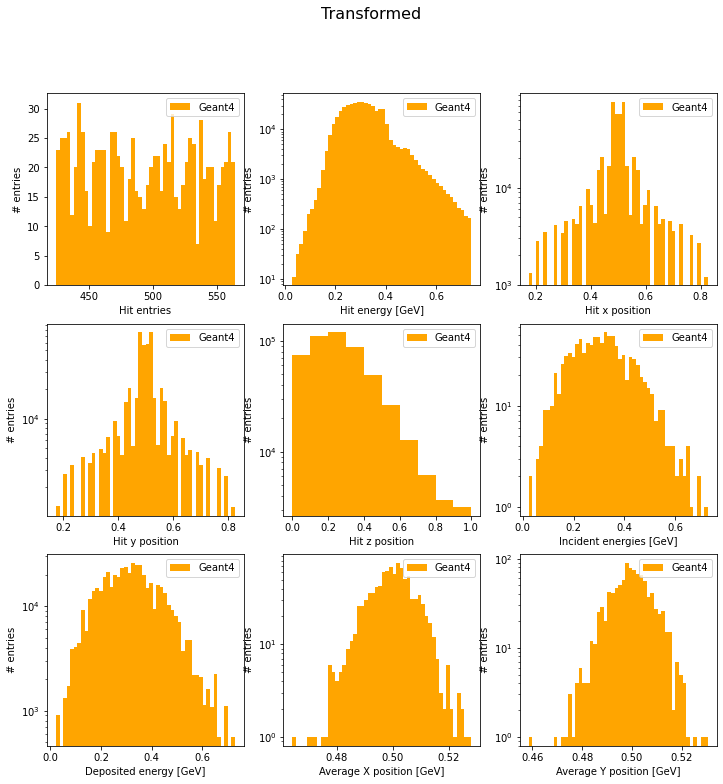

In [7]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
sys.path.insert(1, '../')
import utils
import util.display

dataset = "dataset_2_padded_nentry"
preproc_dataset_name = 'ds2_diff_transforms'
dataset_store_path = os.path.join("/eos/user/j/jthomasw/tdsm_encoder/datasets/", preproc_dataset_name)
jupyternotebook = True
workingdir = "./"
padding_value = 0.0

print('Working directory: ', workingdir)

# Input files
files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '*424To564.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

# Transformed variables
dists_trans = util.display.plot_distribution(files_list_, nshowers_2_plot=1000, padding_value=padding_value)
entries = dists_trans[0]
all_incident_e_trans = dists_trans[1]
total_deposited_e_shower_trans = dists_trans[2]
all_e_trans = dists_trans[3]
all_x_trans = dists_trans[4]
all_y_trans = dists_trans[5]
all_z_trans = dists_trans[6]
all_hit_ine_trans = dists_trans[7]
average_x_shower_trans = dists_trans[8]
average_y_shower_trans = dists_trans[9]

fig, ax = plt.subplots(3,3, figsize=(12,12))
fig.suptitle('Transformed', fontsize=16)
print('Plot # entries')
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, 50, color='orange', label='Geant4')
ax[0][0].legend(loc='upper right')

print('Plot hit energies')
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e_trans, 50, color='orange', label='Geant4')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x_trans, 50, color='orange', label='Geant4')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y_trans, 50, color='orange', label='Geant4')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z_trans, color='orange', label='Geant4')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e_trans, 50, color='orange', label='Geant4')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy per shower')
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower_trans, 50, color='orange', label='Geant4')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot av. X position per shower')
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Average X position [GeV]')
ax[2][1].hist(average_x_shower_trans, 50, color='orange', label='Geant4')
ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')

print('Plot av. Y position per shower')
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Average Y position [GeV]')
ax[2][2].hist(average_y_shower_trans, 50, color='orange', label='Geant4')
ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

save_name = os.path.join(dataset_store_path,'input_dists_transformed.png')
print(f'save to: {save_name}')
fig.savefig(save_name)

## 2D distributions
Now we can look at tsome of the 2D correlation plots between features we want to generate, as well as the conditional incident energy. We can also see the 1D PDF (plotted in the cells above) along the x/y-axis. The z-axis always shows the incident energy. We compare non-transformed with transformed variables. Note that this cell depends on variables set in the cell above e.g. to change the number of showers ghenerated for the Transformed examples, you need to change the number of showers to plot in the cell above and re-run.

In [ ]:
# Non-transformed variables

distributions = [(('X', 'Hit energy [GeV]', 'Incident energy [GeV]') , (all_x, all_e, all_hit_ine, all_x_trans, all_e_trans, all_hit_ine_trans))]
util.display.make_plot(distributions)

distributions = [(('Hit energy [GeV]', 'Incident energy [GeV]', 'Incident energy [GeV]') , (all_e, all_hit_ine, all_hit_ine, all_e_trans, all_hit_ine_trans, all_hit_ine_trans))]
util.display.make_plot(distributions)

distributions = [(('entries', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (entries, total_deposited_e_shower, all_incident_e, entries, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Av. X Position', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (average_x_shower, total_deposited_e_shower, all_incident_e, average_x_shower_trans, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Av. X Position', 'Av. Y Position', 'Incident energy [GeV]') , (average_x_shower, average_y_shower, all_incident_e, average_x_shower_trans, average_y_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Incident energy [GeV]', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (all_incident_e, total_deposited_e_shower, all_incident_e, all_incident_e_trans, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)